In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2, t, f, cauchy, probplot
from scipy.special import kolmogorov

# Задание 1

#### 1. Реализовать генератор схемы Бернулли с заданной вероятностью успеха $p$. Построть на его основе датчик биномиального распределения.

In [2]:
def bern_rnd(p, *shape):
    return (np.random.rand(*shape) < p).astype(int)

In [3]:
def bin_rnd(n, p, *shape):
    return bern_rnd(p, n, *shape).sum(axis = 0)

Тест генератора распределения Бернулли с $p = 0.4$.

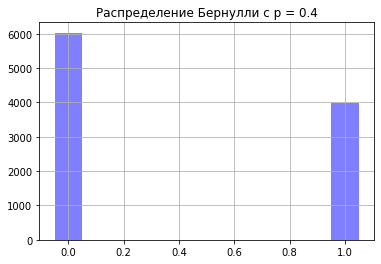

In [4]:
p = 0.4
plt.grid(True)
plt.hist(bern_rnd(p, 10000), bins = np.arange(-0.05, 1.15, 0.1), density=False, color='b', alpha=0.5)
plt.title('Распределение Бернулли с p = 0.4')
plt.show()

Тест генератора биномиального распределения с $n = 10000, p = 0.5$.

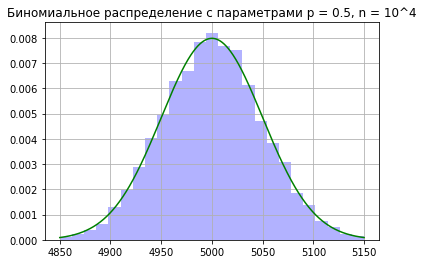

In [5]:
n = 10000
p = 0.5
plt.grid(True)
sigma = np.sqrt(n * p * (1 - p))
mu = n * p
plt.hist(bin_rnd(n, p, 10000), bins = 25, density = True, range=(mu - 3 * sigma, mu + 3 * sigma), color='b', alpha=0.3)
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 1000)
plt.plot(x, norm.pdf((x - mu) / sigma) / sigma, c='g', lw=1.5)
plt.title('Биномиальное распределение с параметрами p = 0.5, n = 10^4')
plt.show()

#### 2. Реализовать генератор геометрического распределения. Проверить для него свойство отсутствия памяти.

Так как случайная величина $\lfloor \xi \rfloor$, где $\xi$ распределена экспоненциально с параметром $\lambda = -\ln(1 - p)$, имеет геометрическое распределение с параметром $p$, достаточно построить генератор экспоненциального распределения методом обращения функции распределения.

In [6]:
def exp_rnd(lam, *shape):
    return -np.log(np.random.rand(*shape)) / lam

In [7]:
def geom_rnd(p, *shape):
    if (p > 1 or p < 0):
        print('p =', p, 'is out of bounds [0, 1]')
        return
    return np.floor(exp_rnd(-np.log(1 - p), *shape))

Проверка отсутствия памяти. Случайные величины $\xi \sim \mathrm{Geom}(p)$ и $\eta = (\xi | \xi \geq \tau) - \tau$ должны иметь одинаковое распределение.

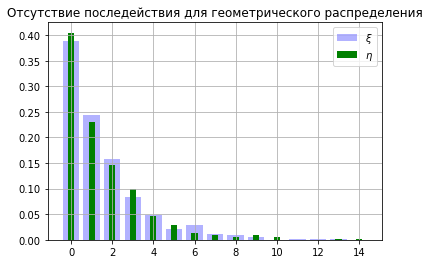

In [8]:
tau = 3
p = 0.4
samp_size = 1000
x = geom_rnd(p, samp_size)
y = geom_rnd(p, int(samp_size / ((1 - p) ** tau)))
y = y[y >= tau]
plt.grid(True)
bns = np.arange(-0.5, 15, 1)
plt.hist(x, bins=bns, rwidth = 0.8, density=True, color='b', alpha = 0.3, label=r'$\xi$')
plt.hist(y - tau, bins=bns, rwidth=0.3, density=True, color='g', label=r'$\eta$')
plt.title('Отсутствие последействия для геометрического распределения')
plt.legend()
plt.show()

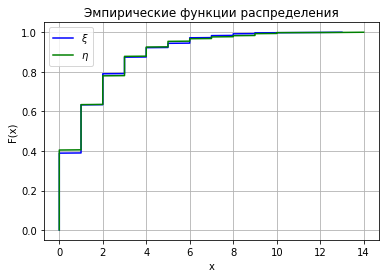

In [9]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf_xi = ECDF(x)
ecdf_eta = ECDF(y)
plt.plot(ecdf_xi.x, ecdf_xi.y, 'b', label=r'$\xi$')
plt.plot(ecdf_eta.x - tau, ecdf_eta.y, 'g', label=r'$\eta$')
plt.legend()
plt.title('Эмпирические функции распределения')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.grid()
plt.show()

#### 3. Рассмотреть игру в орлянку - бесконечную последовательность независимых испытаний с бросанием правильной монеты. Выигрыш $S_n$ определяется как сумма по $n$ испытаниям значений $1$ и $-1$ в зависимости от выпавшей стороны. Проиллюстрировать поведение $Y(i) = \dfrac{S_i}{\sqrt{n}}$ как функцию номера испытания $i = 1, \ldots, n$ для отдельно взятой траектории. Дать теоретическую оценку $Y(n)$ при $n \to \infty$

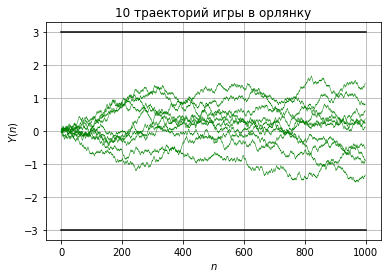

In [10]:
n = 1000
for i in range(0, 10):
    s_n = (2 * bern_rnd(0.5, n) - 1).cumsum()
    plt.plot(s_n / np.sqrt(n), 'g', lw=0.5)
plt.plot([0, n], [3, 3], 'k', [0, n], [-3, -3], 'k')
plt.title('10 траекторий игры в орлянку')
plt.xlabel(r'$n$')
plt.ylabel(r'$Y(n)$')
plt.grid()
plt.show()

При стремлении $n \to \infty$ распределение $Y(n)$ стремится к стандартному нормальному по ЦПТ.

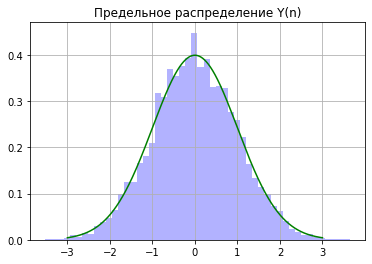

In [11]:
samp_size = 10000
n = 10000
sample = (2 * bern_rnd(0.5, n, samp_size) - 1).sum(0) / np.sqrt(n)
plt.hist(sample, bins=50, density=True, color='b', alpha=0.3)
x = np.linspace(-3, 3, 1000)
plt.plot(x, norm.pdf(x), c='g', lw=1.5)
plt.title('Предельное распределение Y(n)')
plt.grid()
plt.show()

# Задание 2

#### 1. Построить датчик сингулярного распределения, имеющий в качестве функции распределения канторову лестницу. С помощью критерия Колмогорова убедиться в корректности работы датчика.

Для моделирования требуемого распределения воспользуемся тем, что носителем распределения является канторово множество, то есть числа, не имеющие единиц в троичной записи. Заметим также, что если $k$ разрядов случайной величины уже известны, то вероятности того, что $k+1$-й разряд равен $0$ и $2$ одинаковы. Это следует из самоподобия канторовой лестницы. Поэтому будем рассматривать схему Бернулли размера $n$ разрядов числа в троичной системе исчисления с таким n, чтобы ошибка в вычислении числа не превосходила $\varepsilon$.

Так как ошибка равна
$ \sum_{k=n+1}^\infty\left(2/3\right)^{k} = 3^{-n},$
достаточно взять $n \geq \log_3 \varepsilon$.

Итак, будем генерировать схему Бернулли с параметрами $n = \lceil \log_3 \varepsilon \rceil, p = 0.5$, и, в случае успеха на $k$-м испытании будем считать, что $k$-й
разряд генерируемого числа равен 0, а в случае неудачи равен 2.

In [12]:
def cantor_rnd(*shape, eps = 10**10):
    acc = np.ceil(np.log(eps) / np.log(3)).astype(int)
    res = 2 * bern_rnd(0.5, acc, *shape)
    return (res * (np.ones(np.shape(res)) / 3).cumprod(0)).sum(0)

In [13]:
def cant_single(x):
    res = 0
    if x >= 1:
        res = 1
    elif x <= 0:
        res = 0
    else:
        i, k = 1, 0
        while i < 21 and k != 1:
            k = np.floor(3 * x)
            if k == 2:
                res += 1 / 2**i
            elif k == 1:
                res += 1 / 2**i
            i += 1
            x = (x - k / 3) * 3
    return res

In [14]:
def cantor_function(x): 
    if type(x) == int or type(x) == float:
        return cant_single(x)
    res = np.zeros(x.shape)
    for j in enumerate(x):
        res[j[0]] = cant_single(j[1])
    return res

Для проверки генератора воспользуемся критерием Колмогорова. Будем проверять гипотезу
$$H_0\colon \ F(\cdot) = F_0(\cdot),$$
где $F_0(\cdot)$ - функция Кантора. Для этого вычислим
$$D_n = \sup_x|F_n(x) - F_0(x)|,$$
где $F_n(\cdot)$ - эмпирическая функция распределения, построенная по выборке размера $n$. Положим $\gamma = K^{-1}(1-\alpha)$. Здесь $\alpha$ - уровень значимости, а $K^{-1}(x)$ - квантиль распределния Колмогорова порядка $x$. 

Будем отвергать гипотезу в случае, когда
$$\sqrt{n}D_n \geq \gamma.$$

Возьмем $\alpha = 0.05$. Тогда из таблицы распределения Колмогорова $\gamma = K^{-1}(0.95) = 1.36$.

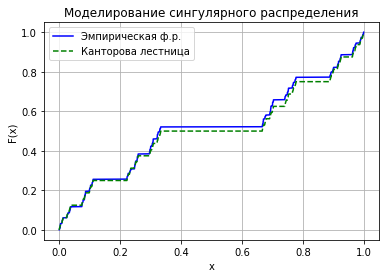

In [15]:
n = 1000
sample = np.sort(cantor_rnd(n))

plt.plot(sample, np.ones(n).cumsum() / n, color='b', label='Эмпирическая ф.р.')

x = np.linspace(0, 1, 1000)
cant = cantor_function(x)
plt.plot(x, cant, 'g--', label='Канторова лестница')
plt.title('Моделирование сингулярного распределения')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.legend()
plt.grid()
plt.show()

Проверка гипотезы

In [16]:
def kolmogorov_test(samp, cdf, alpha): # returns [H0 rejected] and p-value 
    samp = np.sort(samp)
    cant = cdf(samp)
    n = samp.size
    D_plus = np.max(np.abs(np.arange(1, n + 1) / n - cant))
    D_minus = np.max(np.abs(np.arange(0, n) / n - cant))
    D = max(D_plus, D_minus)
    p = kolmogorov(D * np.sqrt(n))
    return [p <= alpha, p]

In [17]:
n = 1000
test_sz = 100
rejected = 0
alpha = 0.05

for i in range(0, test_sz):
    rejected += kolmogorov_test(cantor_rnd(n), cantor_function, alpha)[0]
        
print('Null hypothesis was rejected in', 100 * rejected / test_sz, '% tests.')

Null hypothesis was rejected in 5.0 % tests.


#### 2. Для канторовых случайных величин проверить свойство симметричности относительно 0.5 и самоподобия относительно деления деления на 3 с помощью критерия Смирнова.

In [18]:
def smirnov_test(samp1, samp2, alpha): # returns [H0 rejected] and p-value 
    n1 = samp1.size
    n2 = samp2.size
    samp1 = np.sort(samp1)
    samp2 = np.sort(samp2)
    samp = np.concatenate((samp1, samp2))
    cdf1_r = np.searchsorted(samp1, samp, side='right') / n1
    cdf2_r = np.searchsorted(samp2, samp, side='right') / n2
    cdf1_l = np.searchsorted(samp1, samp, side='left') / n1
    cdf2_l = np.searchsorted(samp2, samp, side='left') / n2
    D = max(np.max(np.abs(cdf1_r - cdf2_r)), np.max(np.abs(cdf1_l - cdf2_l)))
    p = kolmogorov(D * np.sqrt(n1 * n2 / (n1 + n2)))
    return [p <= alpha, p]          

Пусть $X = (x_1, \ldots, x_n), Y = (y_1, \ldots, y_m)$ - выборки, элементы которых имеют функции распределения $F$ и $G$ соответственно, а $F_n, G_m$ - построенные по ним эмпирические функции распределения. Известно, что
$$\mathbb{P}\left(\sqrt{\frac{mn}{m+n}}D_{mn} < x\right) \to K(x).$$
Для проверки гипотезы
$$H_0\colon \ F(\cdot) = G(\cdot),$$
используется тест Смирнова: гипотеза отвергается, если 
$$\sqrt{\frac{mn}{m+n}}D_{mn} > \gamma, \quad \gamma = K^{-1}(1 - \alpha).$$

Как и в прошлом пункте, $\alpha = 0.05, \gamma = 1.36$.

Проверка симметричности.
$X$ - случайная величина с канторовой лестницей в качестве функции распределения. Проверим гипотезу
$$H_0\colon X \overset{d}{=} 1 - X.$$
с помощью критерия Смирнова.

In [19]:
n = 1000
test_sz = 1000
rejected = 0
alpha = 0.05

for i in range(0, test_sz):
    rejected += smirnov_test(cantor_rnd(n), 1 - cantor_rnd(n), alpha)[0]
        
print('Null hypothesis was rejected in', 100 * rejected / test_sz, '% tests.')

Null hypothesis was rejected in 4.5 % tests.


Проверка самоподобия.
$$H_0\colon \dfrac{Y}{3} \overset{d}{=} \left(Y \, \bigg| \, Y \leq \dfrac13\right)$$

In [20]:
n = 1000
test_sz = 1000
rejected = 0
alpha = 0.05

for i in range(0, test_sz):
    samp2 = cantor_rnd(2 * n)
    samp2 = samp2[samp2 <= 1 / 3]
    rejected += smirnov_test(cantor_rnd(n) / 3, samp2, alpha)[0]
        
print('Null hypothesis was rejected in', 100 * rejected / test_sz, '% tests.')

Null hypothesis was rejected in 5.8 % tests.


#### 3. Вычислить значение матожидания и дисперсии для данного распределения. Сравнить теоретические и эмпирические значения, проиллюстрировать сходимость.

В силу симметричности распределения относительно $0.5$, $\mathbb{E}X = 0.5$.
Условия симметричности и самоподобия можно переписать в виде
$$F(x) = 1 - F(1 - x), \quad F\left(\frac{x}{3}\right) = \frac12 F(x), \ x \in [0, \, 1].$$
Вычислим второй момент, пользуясь этими свойствами:
$$\mathbb{E}X^2 = \int_0^1x^2dF(x) = \int_0^{\frac13}x^2dF(x)+\int_\frac23^1 x^2dF(x)$$
После замен переменных, переводящих множество интегрирования в отрезок $[0,\, 1]$, используя свойства симметричности и самоподобия, получим
$$\mathbb{E}X^2 = \frac13 + \frac19\mathbb{E}X^2, \quad \mathbb{E}X^2 = \frac38,$$
откуда легко найти $\mathrm{var\,} \mathrm{X} = \dfrac18.$

Оценим численно математическое ожидание, используя статистику $\overline{x} = \frac{1}{n}\sum_{k=1}^{n}x_k$, и дисперсию, используя статистику ${\hat \sigma}^2 = \frac{1}{n}\sum_{k=1}^{n}(x_k - \overline{x})^2.$

In [21]:
n = 1000
sample = cantor_rnd(n)
print('Estimation of mean:', sample.mean())
print('Estimation of variance:', sample.var())

Estimation of mean: 0.4795258715856193
Estimation of variance: 0.12534217414185678


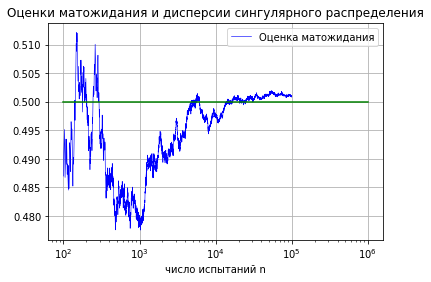

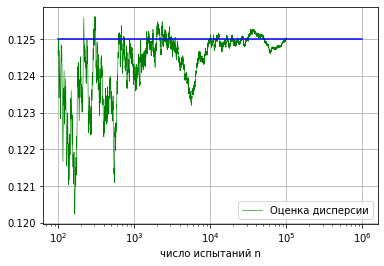

In [22]:
sz = 500
n_max = 10**5
n_min = 10**2
ns = np.logspace(2, 6, sz)
samp = cantor_rnd(n_max)
n_samp = np.arange(n_min, n_max)
means = samp.cumsum()[n_samp] / n_samp
varss = ((samp**2).cumsum())[n_samp] / n_samp - means**2

plt.plot(n_samp, means, c='b', lw = 0.6, label='Оценка матожидания')
plt.plot(ns, 0.5 * np.ones(sz), 'g')
plt.legend()
plt.title('Оценки матожидания и дисперсии сингулярного распределения')
plt.xlabel('число испытаний n')
plt.xscale("log")
plt.grid()
plt.show()

plt.plot(n_samp, varss, c='g', lw = 0.6, label='Оценка дисперсии')
plt.plot(ns, 0.125 * np.ones(sz), 'b')
plt.legend()
plt.xlabel('число испытаний n')
plt.xscale("log")
plt.grid()
plt.show()

# Задание 3

#### 1. Построить датчик экспоненциального распределения. Проверить для данного распределения свойство отсутствия памяти. Пусть $X_1, \ldots, X_n$ независимы и имеют экспоненциальное распределение с параметрами $\lambda_1, \ldots, \lambda_n$. Найти распределение случайной величины $Y = \min(X_1, \ldots, X_n)$.

Датчик экспоненциального распределения exp_rnd был построен методом обращения функции распределения в задании 1.2.

Отсутствие памяти.

<function matplotlib.pyplot.show(*args, **kw)>

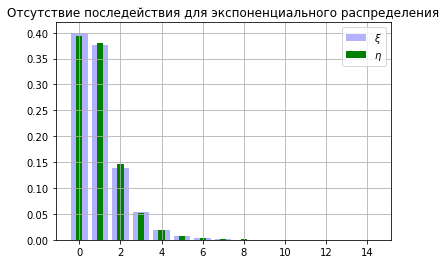

In [23]:
tau = 3
lam = 1
samp_size = 10000
x = exp_rnd(lam, samp_size)
y = exp_rnd(lam, int(samp_size * (np.exp(lam * tau))))
y = y[y >= tau]
plt.grid(True)
bns = np.arange(-0.5, 15, 1)
plt.hist(x, bins=bns, rwidth = 0.8, density=True, color='b', alpha=0.3, label=r'$\xi$')
plt.hist(y - tau, bins=bns, rwidth=0.3, density=True, color='g', label=r'$\eta$')
plt.title('Отсутствие последействия для экспоненциального распределения')
plt.legend()
plt.show

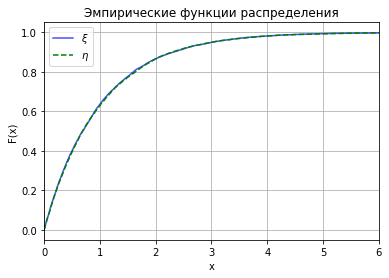

In [24]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf_xi = ECDF(x)
ecdf_eta = ECDF(y)
plt.plot(ecdf_xi.x, ecdf_xi.y, 'b', alpha=0.7, label=r'$\xi$')
plt.plot(ecdf_eta.x - tau, ecdf_eta.y, 'g--', label=r'$\eta$')
plt.xlim((0, 6))
plt.legend()
plt.title('Эмпирические функции распределения')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.grid()
plt.show()

Найдем распределение $Y$:
$$F_Y(x) = \mathbb{P}(\min(X_1, \ldots, X_n) < x) = 1 - \mathbb{P}(X_1 \geq x, \ldots, X_n \geq x) = 1 - \prod_{k=1}^n(1- F_{X_k}(x)) = 1 - e^{-\sum \lambda_i x},$$
откуда $Y \sim \mathrm{exp}\left(\sum_{k=1}^n \lambda_k\right)$.

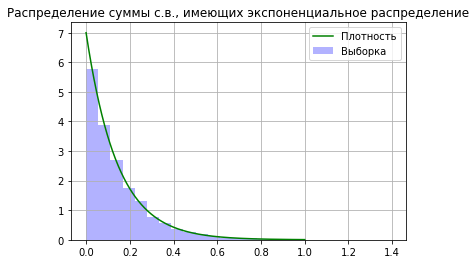

In [25]:
lam1 = 2
lam2 = 1
lam3 = 4
sz = 10000
samp = np.zeros((3, sz))
samp[0] = exp_rnd(lam1, sz)
samp[1] = exp_rnd(lam2, sz)
samp[2] = exp_rnd(lam3, sz)
samp = np.vstack((samp[0], samp[1], samp[2])).min(axis=0)
plt.hist(samp, bins=25, density=True, color='b', alpha = 0.3, label = 'Выборка')
x = np.linspace(0, 1, 1000)
plt.plot(x, (lam1 + lam2 + lam3) * np.exp(-(lam1 + lam2 + lam3) * x), c='g', lw= 1.5, label='Плотность')
plt.title('Распределение суммы с.в., имеющих экспоненциальное распределение')
plt.legend()
plt.grid()
plt.show()

#### 2. На основе датчика экспоненциального распределения построить датчик пуассоновского распределения.

Известно, что время между скачками пуассоновского процесса $X(t)$ с интенсивностью $\lambda$ имеет экспоненциальное распределение с параметром $\lambda$. При этом $X(1)$ имеет распределение Пуассона с параметром $\lambda$. Таким образом, при моделировании $\xi_k \sim \exp(\lambda)$ до тех пор, пока их сумма не достигнет 1
$$\sum_{k=1}^\eta \xi_k > 1,$$
величина $\eta - 1$ будет иметь требуемое пуассоновское распределение.

In [26]:
def pois_exp_single(lam):
    sum = 0
    res = -1
    while sum <= 1:
        sum += exp_rnd(lam, 1)
        res += 1
    return res

In [27]:
def pois_exp_rnd(lam, *shape):
    n = np.prod(shape)
    res = np.zeros(n)
    for i in range(0, n):
        res[i] = pois_exp_single(lam) 
    return np.reshape(res, shape)

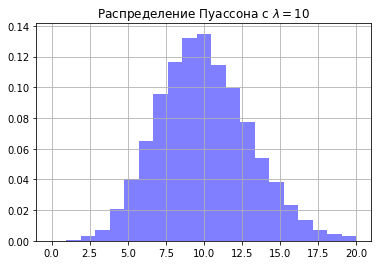

In [28]:
sample = pois_exp_rnd(10, 10000)
plt.hist(sample, density=True, range=(0, 20), bins=21, color='b', alpha=0.5)
plt.title(r'Распределение Пуассона с $\lambda=10$')
plt.grid()
plt.show()

#### 3. Построить датчик пуассоновского распределения как предел биномиального. С помощью критерия хи-квадрат убедиться, что получен датчик распределения Пуассона.

По теореме Пуассона биномиальное распределение с малым $p$ и $n$ таким, что $np = \lambda$ будет приблизительно совпадать с пуассоновским распределением с параметром $\lambda$. Точнее, пусть $\nu_n \sim \mathrm{Bi}(n, \, p)$. Тогда верная следующая оценка
$$\left|\mathbb{P}(\nu_n \in A) - \sum_{k \in A}e^{-\lambda}\frac{\lambda^k}{k!}\right| \leq np^2 = \lambda p.$$

Потребуем, чтобы ошибка не превосходила $\varepsilon = 0.001$. Будем моделировать биномиальное распределение с параметрами $p = \frac{\varepsilon}{\lambda}, n = \frac{\lambda}{p}$.

In [29]:
def pois_bin_rnd(lam, *shape):
    eps = 0.001
    p = eps / lam
    n = int(lam / p)
    return bin_rnd(n, p, *shape)

Проверим построенный генератор при $\lambda = 4$ при помощи критерия хи-квадрат. Рассмотрим следующее расбиение множества целых неотрицательных чисел:
$$\Delta_1 = \{0, \ 1\}, \Delta_2 = \{2\}, \Delta_3 = \{3\}, \Delta_4 = \{4\}, \Delta_5 = \{5\}, \Delta_6 = \{6\}, \Delta_2 = \{k \geq 7\}.$$
Вычислим вероятности попадания в каждое множество:
$$p_i = \mathbb{P}(\Delta_i).$$

In [30]:
def pois_prob(lam, k):
    return np.exp(-lam) * lam**k / np.prod(range(1, k + 1))

In [31]:
lam = 4
p = np.zeros(7)
p[0] = pois_prob(lam, 0) + pois_prob(lam, 1)
p[1] = pois_prob(lam, 2)
p[2] = pois_prob(lam, 3)
p[3] = pois_prob(lam, 4)
p[4] = pois_prob(lam, 5)
p[5] = pois_prob(lam, 6)
p[6] = 1 - p[0:6].sum()
%precision 4
print(p)

[0.0916 0.1465 0.1954 0.1954 0.1563 0.1042 0.1107]


Для проверки гипотезы
$$H_0 \colon X \sim \mathrm{Pois}(\lambda)$$ с уровнем значимости $\alpha = 0.05$
будем использовать статистику
$$Q = \sum_{i = 1}^{7} \frac{(N_i - np_i)^2}{np_i},$$
где $N_i$ - число элементов выборки, попавший в $\Delta_i$, $n$ - размер выборки.

Будем отклонять гипотезу, если $Q \geq \gamma, \ \gamma = \chi_6^{-1}(1 - \alpha)$. $\chi_6^{-1}(x)$ - квантиль распределения хи-квадрат с 6 степенями свободы порядка $x$. 

In [32]:
def chi2_test(samp, sets, probs, alpha): # returns True if rejects H0
    n = sets.shape[0]
    gamma = chi2.ppf(1 - alpha, n - 1)
    ns = np.zeros(n)
    for i in range(0, n):
        ns[i] = ((samp >= sets[i][0]) * (samp <= sets[i][1])).sum()
    sz = samp.size
    q = ((ns - sz * p) ** 2 / (sz * p)).sum()
    return q > gamma

In [33]:
n = 500
test_sz = 100
alpha = 0.05

rejected = 0
sets = np.array([[0, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, np.inf]])

for i in range(0, test_sz):
    samp = pois_bin_rnd(lam, n)
    rejected += chi2_test(samp, sets, p, alpha)
        
print('Null hypothesis was rejected in', 100 * rejected / test_sz, '% tests.')

Null hypothesis was rejected in 4.0 % tests.


#### 4. Построить датчик стандартного нормального распределения методом моделирования случайных величин с переходом в полярные координаты. Проверить при помощи t-критерия Стьюдента равенство матожиданий, а при помощи критерия Фишера равенство дисперсий.

In [34]:
def norm_polar_rnd(mu, sigma, *shape):
    size = np.prod(shape)
    n = int(np.ceil(size / 2))
    r = np.sqrt(exp_rnd(0.5, n))
    angle = 2 * np.pi * np.random.rand(n)
    res = np.concatenate([r * np.sin(angle), r * np.cos(angle)])
    return np.reshape(sigma * res[0:size] + mu, shape)

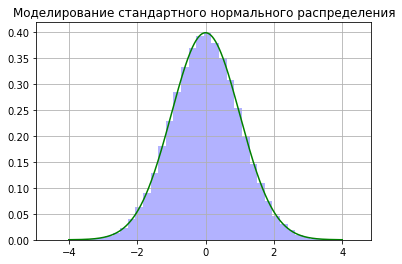

In [35]:
samp = norm_polar_rnd(0, 1, 100000)
plt.hist(samp, bins=40, density=True, color = 'b', alpha = 0.3)
x = np.linspace(-4, 4, 1000)
plt.plot(x, norm.pdf(x), c='g', lw = 1.5)
plt.title('Моделирование стандартного нормального распределения')
plt.grid()
plt.show()

Проверим правильность работы датчика для $\mu = 1, \sigma = 2$ с помощью t-теста Стьюдента. Для выборки размера $n$ вычислим статистики
$$\sigma' = \sqrt{\dfrac{1}{n-1}\sum_i(X_i - \bar X)^2},$$
$$U = \sqrt{n}\frac{\bar X - \mu}{\sigma'}.$$
Если элементы выборки имеют нормальное распределение с матожиданием $\mu$, то $U$ имеет распределение Стьюдента с $n - 1$ степенью свободы.

Положим уровень значимости $\alpha = 0.05$. Будем отклонять гипотезу
$$H_0\colon\ \mathbb{E}X = \mu,$$
когда $|U| \geq \gamma, \ \gamma = T_n^{-1}\left(1 - \frac{\alpha}{2}\right).$

In [36]:
def t_test(samp, mu, alpha):
    n = samp.size
    gamma = t.ppf(1 - alpha / 2, n - 1)
    U = np.sqrt(n) * (samp.mean() - mu) / np.sqrt(samp.var() * n / (n - 1))
    return abs(U) > gamma

In [37]:
test_sz = 100
rejected = 0
n = 1000
alpha = 0.05

mu = 1
sigma = 2

for i in range(0, test_sz):
    samp = norm_polar_rnd(mu, sigma, n)
    rejected += t_test(samp, mu, alpha)
        
print('Null hypothesis was rejected in', 100 * rejected / test_sz, '% tests.')

Null hypothesis was rejected in 6.0 % tests.


Проверим равенство дисперсий нормального распределения с параметрами $\mu = 1, \sigma = 2$ для построенного датчика и датчика numpy.random.randn с помощью критерия Фишера. Рассмотрим выборки $X = (X_1, \ldots, X_n), \ Y = (Y_1, \ldots, Y_m)$. Для них статистика
$$ V = \dfrac{m-1}{n-1}\dfrac{\sum_i(X_i - \bar X)^2}{\sum_i(Y_i - \bar Y)^2}$$ 
имеет распределение Фишера с параметрами $n - 1$ и $m - 1$ соответственно.

Будем отклонять гипотезу
$$H_0\colon \sigma_1 = \sigma_2,$$
если $V \leq \gamma_1$ или $V \geq \gamma_2$. Здесь
$\gamma_1 = F_{n-1, m-1}^{-1}\left(\frac{\alpha}{2}\right), 
\gamma_2 = F_{n-1, m-1}^{-1}\left(1 - \frac{\alpha}{2}\right), F_{n-1, m-1}^{-1}(x)$ - квантиль F-распределения с параметрами $n - 1$ и $m - 1$ порядка $х$.

In [38]:
def f_test(samp1, samp2, alpha):
    n = samp1.size
    m = samp2.size
    gamma1 = f.ppf(alpha / 2, n - 1, m - 1)
    gamma2 = f.ppf(1 - alpha / 2, n - 1, m - 1)
    V = samp1.var() / samp2.var() * n / m * (m - 1) / (n - 1)
    return V < gamma1 or V > gamma2

In [39]:
test_sz = 100
rejected = 0
alpha = 0.05

mu = 1
sigma = 2


for i in range(0, test_sz):
    samp1 = norm_polar_rnd(mu, sigma, n)
    samp2 = sigma * np.random.randn(n) + mu
    rejected += f_test(samp1, samp2, alpha)
        
print('Null hypothesis was rejected in', 100 * rejected / test_sz, '% tests.')

Null hypothesis was rejected in 10.0 % tests.


# Задание 4

#### 1. Построить датчик распределения Коши.

Функция распределения случайной величины, имеющей распределение Коши с параметром сдвига $x_0$ и параметром масштаба $\gamma$, имеет вид
$$F(x) = \frac{1}{\pi} \arctan\left(\frac{x-x_0}{\gamma}\right) + \frac12.$$

Обратная к ней
$$Q(p) = x_0 + \gamma \tan\left(\pi\left(p - \frac12\right)\right).$$

Будем использовать ее для моделирования распределения Коши:
$$\xi = Q(U) \sim \mathcal{C}(x_0, \gamma), \quad U \sim \mathcal{U}(0, 1).$$

In [40]:
def cauchy_rnd(x0, gamma, *shape):
    return x0 + gamma * np.tan(np.pi * (np.random.rand(*shape) - 0.5))

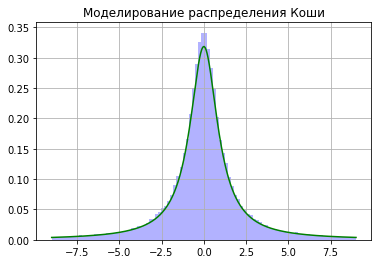

In [41]:
samp = cauchy_rnd(0, 1, 100000)
plt.hist(samp, density=True, bins=100, range=(-9, 9), color = 'b', alpha = 0.3)
x = np.linspace(-9, 9, 1000)
plt.plot(x, cauchy.pdf(x), 'g', lw=1.5)
plt.title('Моделирование распределения Коши')
plt.grid()
plt.show()

#### 2. На основе датчика распределения Коши с помощью метода фон Неймана построить датчик стандартного нормального распределения. Убедиться в корректности построенного датчика и обосновать наблюдаемую линейную зависимость.

Описание метода элиминации фон Неймана.

Пусть имеется датчик распределения с плотностью $g(\cdot)$ (в этой задаче 
$g(x) = \frac{\gamma}{\pi[(x - x_0)^2 + \gamma^2]}$), и требуется смоделировать случайную величину с плотностью $f(\cdot)$ (в нашем случае $f(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}})$, причем
$$\sup_x \frac{f(x)}{g(x)} \leq k.$$

Будем использовать следующий алгоритм:
1. Моделируем $X \sim g$ и равномерно распределенную на единичном отрезке случайную  величину $U$.
2. Если $$\frac{f(X)}{g(X)} \geq kU,$$
то $Y = X$, и процесс завершается, в противном случае нужно вернуться у шагу 1.

Полученная таким образом случайная величина $Y$ имеет требуемое распределение $f$.

Нетрудно показать, что наилучшее приближение стандартного нормального распределения распределением Коши имеет параметры $x_0 = 0, \gamma = 1$. При этом
$$k = \sup_x \frac{f(x)}{g(x)} = \sqrt{2\pi}e^{-\frac12}.$$

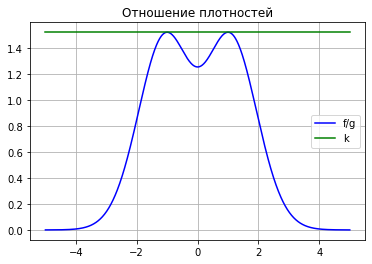

In [42]:
k = np.sqrt(2 * np.pi) * np.exp(-0.5)
x = np.linspace(-5, 5, 1000)
f = 1 / np.sqrt(2 * np.pi) * np.exp(-x**2 / 2)
g = 1 / (np.pi * (x**2 + 1))
plt.plot(x, f / g, 'b', label='f/g')
plt.plot([-5, 5], [k, k], 'g', label='k')
plt.title('Отношение плотностей')
plt.legend()
plt.grid()
plt.show()

In [43]:
def norm_neumann_rnd(mu, sigma, *shape):
    res = np.zeros(0)
    n = np.prod(shape)
    while res.size < n:
        u = np.random.rand(n)
        x = cauchy_rnd(0, 1, n)
        k = np.sqrt(2 * np.pi) * np.exp(-0.5)
        f = 1 / np.sqrt(2 * np.pi) * np.exp(-x**2 / 2)
        g = 1 / (np.pi * (x**2 + 1))
        res = np.concatenate([res, x[f / g >= k * u]])
    return np.reshape(sigma * res[0:n] + mu, shape)

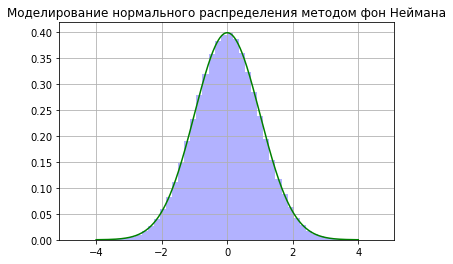

In [44]:
samp = norm_neumann_rnd(0, 1, 10**6)
plt.hist(samp, density=True, bins=50, color='b', alpha=0.3)
x = np.linspace(-4, 4, 1000)
plt.plot(x, norm.pdf(x), c='g', lw=1.5)
plt.title('Моделирование нормального распределения методом фон Неймана')
plt.grid()
plt.show()

In [45]:
def my_normplot(samp, mu, sigma):
    (quants, vals), (slope, inter, _) = probplot(samp, dist='norm')
    plt.plot(vals, quants, 'o', color = 'g', alpha = 0.5)
    plt.plot(quants * slope + inter, quants, 'k')
    ticks_perc=np.array([1, 5, 10, 20, 50, 80, 90, 95, 99])
    ticks_quan=np.array([norm.ppf(i/100.) for i in ticks_perc])
    plt.yticks(ticks_quan, ticks_perc)
    plt.xlabel('Выборка')
    plt.ylabel('Вероятность, %')
    plt.grid()
    plt.show()

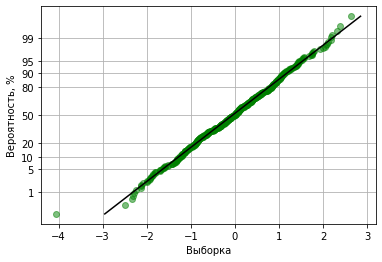

In [46]:
mu = 0
sigma = 1
samp = norm_neumann_rnd(mu, sigma, 500)
my_normplot(samp, mu, sigma)

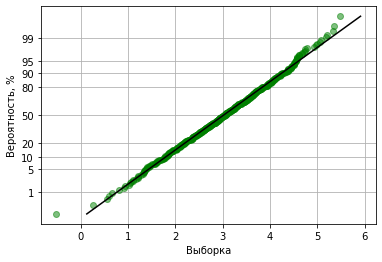

In [47]:
mu = 3
sigma = 1
samp = norm_neumann_rnd(mu, sigma, 500)
my_normplot(samp, mu, sigma)

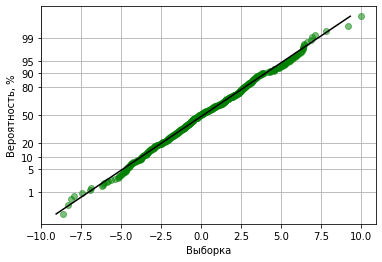

In [48]:
mu = 0
sigma = 3
samp = norm_neumann_rnd(mu, sigma, 500)
my_normplot(samp, mu, sigma)

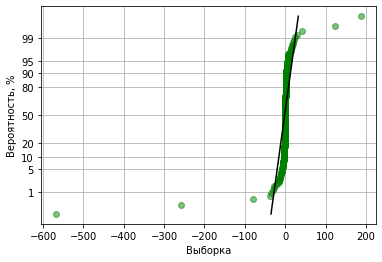

In [49]:
samp = cauchy_rnd(0, 1, 500)
my_normplot(samp, mu, sigma)

Для стандартного нормального распределения точки лежат на прямой по построению: ось ординат деформируется так, чтобы функция нормального распределения была линейной. Таким образом, если $\xi \sim \mathcal{N}(0, 1)$, то $F(x) = \mathbb{P}(\xi < x)$ линейна на таком графике. Произвольную нормальную случайную величину можно представить в виде $\eta = \sigma \xi + \mu$, и для нее
$$\mathbb{P}(\eta < x) = \mathbb{P}\left(\xi < \frac{x - \mu}{\sigma}\right)$$
также будет линейной на этом графике. При этом происходит сдвиг на $\mu$ по оси абсцисс, а угловой коэффициент умножается на $\dfrac{1}{\sigma}$.

#### 3. Сравнить скорость моделирования стандартного нормального распределения в заданиях 3 и 4

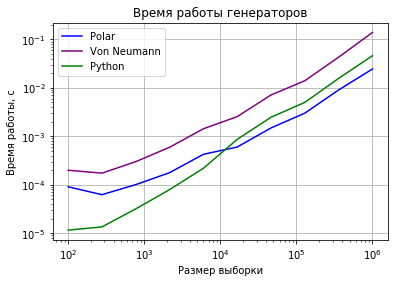

In [50]:
from time import time

n = 10
sizes = np.logspace(2, 6, n).astype(int)
times_pol = np.zeros((10, n))
times_neum = np.zeros((10, n))
times_python = np.zeros((10, n))
for s in enumerate(sizes):
    for i in range(0, 10):
        t = time()
        norm_polar_rnd(0, 1, s[1])
        times_pol[i][s[0]] = time() - t
        t = time()
        norm_neumann_rnd(0, 1, s[1])
        times_neum[i][s[0]] = time() - t
        t = time()
        np.random.randn(s[1])
        times_python[i][s[0]] = time() - t
times_pol = np.median(times_pol, axis=0)
times_neum = np.median(times_neum, axis=0)
times_python = np.median(times_python, axis=0)
plt.plot(sizes, times_pol, label='Polar', c='b')
plt.plot(sizes, times_neum, label='Von Neumann', c='purple')
plt.plot(sizes, times_python, label='Python', c='g')
plt.legend()
plt.title('Время работы генераторов')
plt.xlabel('Размер выборки')
plt.ylabel('Время работы, с')
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.show()

# Задание 5

#### 1. Пусть $X_i \sim \mathcal{N}(\mu, \sigma^2)$. Убедиться эмпирически в справедливости ЗБЧ и ЦПТ: исследовать поведение суммы $S_n$ и эмпирического распределения величины
$$\sqrt{n}\left(\frac{S_n}{n} - a\right).$$

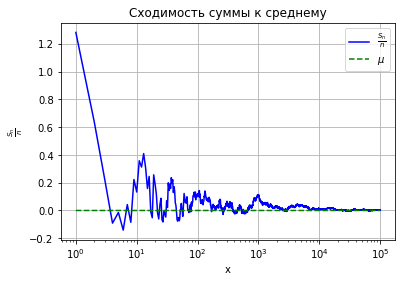

In [51]:
n = 10**5
mu = 0
sigma = 2
samp = norm_polar_rnd(mu, sigma, n)
sn = samp.cumsum()
x = np.arange(1, n + 1)
plt.plot(x, sn / x, 'b', label=r'$\frac{S_n}{n}$')
plt.plot(x, mu * x, 'g--', label=r'$\mu$')
plt.title('Сходимость суммы к среднему')
plt.xlabel('x')
plt.xscale("log")
plt.ylabel(r'$\frac{S_n}{n}$')
plt.legend()
plt.grid()
plt.show()

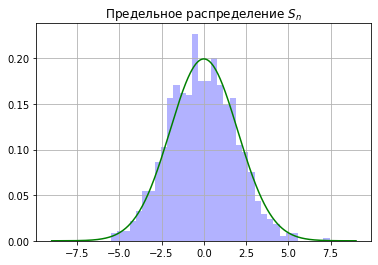

In [52]:
samp_sz = 10**3
samp = (norm_polar_rnd(mu, sigma, n, samp_sz).sum(0) / n - mu) * np.sqrt(n)
plt.hist(samp, density=True, bins=35, color='b', alpha=0.3)
x = np.linspace(-9, 9, 1000)
plt.plot(x, 1 / sigma * norm.pdf(x / sigma), c='g', lw = 1.5)
plt.title(r'Предельное распределение $S_n$')
plt.grid()
plt.show()

По ЦПТ распределение $\sqrt{n}\left(\frac{S_n}{n} - a\right)$ стремится по распределению к $\mathcal{N}(0, \sigma^2)$.

#### 2. Считая $\mu$ и $\sigma$ неизвестными, для пункта 1 построить доверительные интервалы для среднего и дисперсии.

Так как статистика $$U = \sqrt{n}\frac{\bar X - \mu}{\sigma'}, \quad \sigma' = \frac{1}{n-1}\sum_i(X_i - \bar X)^2$$
имеет распределение Стьюдента с $n - 1$ степенью свободы, можно построить доверительный интервал с уровнем доверия $\alpha = 0.95$ следующим образом:
$$\mathbb{P}(\gamma_1 < U < \gamma_2) = \mathbb{P}\left(\bar X - \frac{\sigma'\gamma_2}{\sqrt{n}} < \mu < \bar X - \frac{\sigma'\gamma_1}{\sqrt{n}}\right) = 1 - \alpha.$$
Значения $\gamma_1$ и $\gamma_2$ выберем так, чтобы интервал был симметричным:
$$\gamma_1 = T^{-1}_{n-1}\left(\frac{1 - \alpha}{2}\right),\  \gamma_2 = T^{-1}_{n-1}\left(\frac{1 + \alpha}{2}\right).$$
Итак, доверительный интервал для параметра $\mu$ имеет вид
$$\left(\bar X - \frac{\sigma'\gamma_2}{\sqrt{n}}, \ \bar X - \frac{\sigma'\gamma_1}{\sqrt{n}}\right).$$

In [53]:
from scipy.stats import t

alpha = 0.95
n = 1000
gamma1 = t.ppf((1 - alpha) / 2, n - 1)
gamma2 = t.ppf((1 + alpha) / 2, n - 1)
print(gamma1, gamma2)

-1.9623414611334487 1.9623414611334487


In [54]:
mu = 1
sigma = 2
in_inter = 0

test_sz = 100
for i in range(0, test_sz):
    samp = norm_polar_rnd(mu, sigma, n)
    s = np.sqrt(samp.var() * n / (n - 1))
    A = samp.mean() - gamma2 * s / np.sqrt(n)
    B = samp.mean() - gamma1 * s / np.sqrt(n)
    if mu > A and mu < B:
        in_inter += 1
        
print('Mu lies in confidence interval in ', 100 * in_inter / test_sz, '% of tests.')

Mu lies in confidence interval in  96.0 % of tests.


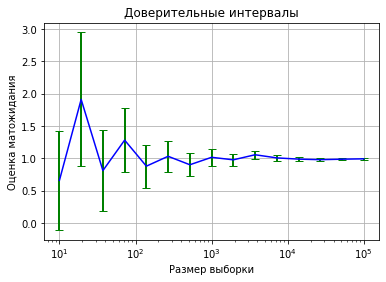

In [55]:
N = 15
sizes = np.logspace(1, 5, N)
errs = np.zeros(N)
means = np.zeros(N)

for i, n in enumerate(sizes):
    sz = int(n)
    samp = norm_polar_rnd(mu, sigma, sz)
    s = np.sqrt(samp.var() * sz / (sz - 1))
    gamma2 = t.ppf((1 + alpha) / 2, sz - 1)
    errs[i] = gamma2 * s / np.sqrt(sz)
    means[i] = samp.mean()

fig, ax = plt.subplots()
ax.errorbar(sizes, means, yerr=errs, capsize=4, elinewidth=2, ecolor='green', color='b')
ax.set_xscale('log')
ax.set_xlabel('Размер выборки')
ax.set_ylabel('Оценка матожидания')
ax.set_title('Доверительные интервалы')
ax.grid()

Для оценки дисперсии будем использовать статистику
$$V = \frac{\sum_i(X_i - \bar X)^2}{\sigma^2} \sim \chi^2(n - 1).$$
Пусть снова $\alpha = 0.95$. 
$$\mathbb{P}(\gamma_1 < V < \gamma_2) = \mathbb{P}\left(\frac{\sum_i(X_i - \bar X)^2}{\gamma_2} < \sigma^2 < \frac{\sum_i(X_i - \bar X)^2}{\gamma_1}\right) = 1 - \alpha.$$
Для построения симметричного интервала
$$\gamma_1 = \chi^{-1}\left(\frac{1-\alpha}{2}\right), \ \gamma_2 = \chi^{-1}\left(\frac{1+\alpha}{2}\right).$$
Доверительный для $\sigma^2$ с уровнем доверия $\alpha$ имеет вид
$$\left(\frac{\sum_i(X_i - \bar X)^2}{\gamma_2}, \ \frac{\sum_i(X_i - \bar X)^2}{\gamma_1}\right).$$

In [56]:
alpha = 0.95
n = 1000
gamma1 = chi2.ppf((1 - alpha) / 2, n - 1)
gamma2 = chi2.ppf((1 + alpha) / 2, n - 1)
print(gamma1, gamma2)

913.3009983021134 1088.4870677259353


In [57]:
mu = 0
sigma = 2
in_inter = 0

test_sz = 100
for i in range(0, test_sz):
    samp = norm_polar_rnd(mu, sigma, n)
    A = n * samp.var() / gamma2
    B = n * samp.var() / gamma1
    if sigma**2 > A and sigma**2 < B:
        in_inter += 1
        
print('Variance lies in confidence interval in ', 100 * in_inter / test_sz, '% of tests.')

Variance lies in confidence interval in  93.0 % of tests.


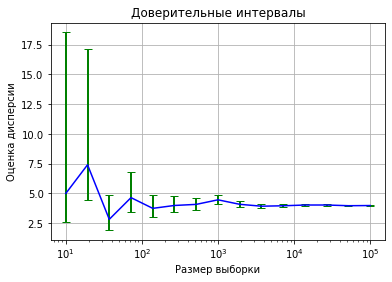

In [61]:
N = 15
sizes = np.logspace(1, 5, N)
errs = np.zeros((2, N))
vrs = np.zeros(N)

for i, n in enumerate(sizes):
    samp = norm_polar_rnd(mu, sigma, int(n))
    gamma1 = chi2.ppf((1 - alpha) / 2, int(n) - 1)
    gamma2 = chi2.ppf((1 + alpha) / 2, int(n) - 1)
    vrs[i] = samp.var()
    errs[0, i] = vrs[i] - int(n) * samp.var() / gamma2
    errs[1, i] = int(n) * samp.var() / gamma1 - vrs[i]

fig, ax = plt.subplots()
ax.errorbar(sizes, vrs, yerr=errs, capsize=4, elinewidth=2, ecolor='green', color='b')
ax.set_xscale('log')
ax.set_xlabel('Размер выборки')
ax.set_ylabel('Оценка дисперсии')
ax.set_title('Доверительные интервалы')
ax.grid()

#### 3. Пусть $X_i \sim \mathcal{C}(a, b)$ имеет распределение Коши со сдвигом $a$ и масштабом $b$. Проверить эмпирически, как ведут себя суммы $\frac{S_n}{n}$. Результат объяснить, а также найти распределения данных сумм.

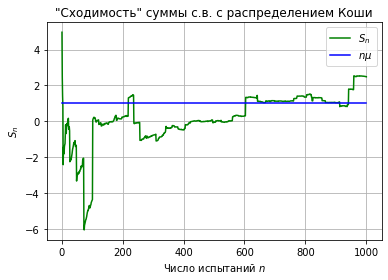

In [59]:
n = 10**3
a = 1
b = 2
samp = cauchy_rnd(a, b, n)
sn = samp.cumsum()
x = np.array(range(1, n + 1))
plt.plot(x, sn / x, 'g', label=r'$S_n$')
plt.plot(x, a * np.ones(x.shape), 'b', label=r'$n\mu$')
plt.title('"Сходимость" суммы с.в. с распределением Коши')
plt.xlabel(r'Число испытаний $n$')
plt.ylabel(r'$S_n$')
plt.grid()
plt.legend()
plt.show()

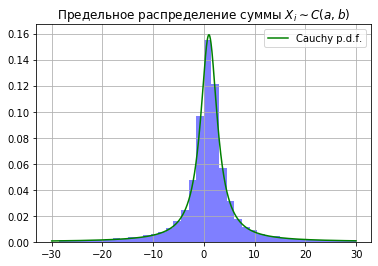

In [60]:
samp_sz = 10**4
samp = (cauchy_rnd(a, b, n, samp_sz).sum(0) / n)
plt.hist(samp, density=True, bins=40, range=(-30, 30), color='blue', alpha=0.5)
x = np.linspace(-30, 30, 1000)
plt.plot(x, 1 / np.pi * b / ((x - a)**2 + b**2), 'g', lw=1.5, label='Cauchy p.d.f.')
plt.legend()
plt.title(r'Предельное распределение суммы $X_i \sim C(a, b)$')
plt.grid()
plt.show()

Найдем распределение $\frac{S_n}{n}$ с помощью характеристической функции распределения Коши:
$$\varphi(t) = \mathbb{E}e^{it\xi} = \frac1\pi\int\frac{be^{itx}}{(x - a)^2 + b^2}dx = \frac{e^{ita}}{\pi}\int\frac{e^{itbx}}{x^2 + 1}dx = e^{ita - |t|b}.$$
Тогда характеристическая функция $\frac{S_n}{n}$ имеет вид
$$\varphi_{\frac{S_n}{n}}(t) = \left[\varphi\left(\frac{t}{n}\right)\right]^n = \varphi(t),$$
поэтому $\frac{S_n}{n} \sim \mathcal{C}(a, b)$.

# Задание 6

#### 1. Посчитать интеграл
$$J = \int\limits_{-\infty}^{+\infty}\int\limits_{-\infty}^{+\infty}\ldots\int\limits_{-\infty}^{+\infty} \dfrac{e^{-\left(x_1^2 + \ldots + x_{10}^2 + \frac{1}{2^7x_1^2\ldots x_{10}^2}\right)}}{x_1^2\ldots x_{10}^2}dx_1dx_2\ldots dx_{10}$$

#### a) методом Монте-Карло;

#### b) методом квадратур, сводя задачу к вычислению собственного интеграла Римана.

a) Отметим, что случайный вектор $X = (X_1, \ldots, X_{10})$, у которого каждая компонента распределена нормально с $\mu = 0,\ \sigma^2 = \frac12$, имеет плотность
$$p(x) = \frac{1}{\pi^5}e^{-(x_1^2 + \ldots + x_{10}^2)}.$$
Перепишем интеграл в виде
$$ J = \pi^5 \int\limits_{\mathbb{R}^{10}} ye^{-\frac{y}{128}}p(x)dx, \quad y = \left(\prod_{k=1}^{10} x_k\right)^{-2}$$
и заметим, что он равен математическому ожиданию
$\mathbb{E}f(Y),$
где $f(y) = \pi^5 y e^{-\frac{y}{128}},\ Y = \left(\prod_{k=1}^{10} X_k\right)^{-2}$, а $X_k \sim \mathcal{N}\left(0, \frac12\right)$ и независимы.

По ЗБЧ $\frac1n \sum_k f(y_k) \to \mathbb{E}f(Y) = J$.

In [110]:
def int_func(x):
    return np.pi ** 5 * x * np.exp(-x / 128)

In [155]:
def int_mc(n):
    return int_func(norm_polar_rnd(0, 1 / np.sqrt(2), n, 10).prod(1)**(-2)).mean()

In [161]:
n = 10**7
res = int_func(norm_polar_rnd(0, 1 / np.sqrt(2), 10, n).prod(0)**(-2)).mean()
print(res)

125.14084909144852


При $n = 10^7$ метод Монте-Карло дает результат $J \approx 124.8$.

b) Сделаем в интеграле замену $x_k = \tan\left(y_k\right), \ dx_k = \dfrac{dy_k}{\cos^2\left(y_k\right)}, \ k = 1, \ldots, 10.$
После замены и некоторых упрощений интеграл примет вид
$$\int\limits_{-\frac{\pi}{2}}^{\frac{\pi}{2}}\ldots\int\limits_{-\frac{\pi}{2}}^{\frac{\pi}{2}} \exp \left\{-\sum\limits_k \tan^2(y_k) - \dfrac{1}{128}\prod\limits_k \cot^2 (y_k)\right\}\prod\limits_k \dfrac{1}{\sin^2(y_k)}dy_1\ldots dy_{10}$$

Обозначим подынтегральную функцию $f(y_1, \ldots, y_{10})$ и заметим, что она симметрична и четна по всем аргументам.

Построим равномерную сетку размера $m$ на каждом отрезке $\left[-\dfrac{\pi}{2}, \dfrac{\pi}{2}\right]$:
$$x_i = -\frac{\pi}{2} + h(i + 0.5), \quad i = 0, \ldots, m-1,$$
В силу четности $f$ можно вычислить интеграл на $\left[0, \dfrac{\pi}2\right]$ по каждому измерению, и затем умножить результат на $2^{10}$.

$h = \dfrac{\pi}{m}$ - шаг сетки. Элементы сетки - центры отрезков, полученных при разбиении $\left[-\dfrac{\pi}{2}, \dfrac{\pi}{2}\right]$ на $m$ равных частей. Разобьем $\left[-\dfrac{\pi}{2}, \dfrac{\pi}{2}\right]^{10}$ на гиперкубики с центрами $(x_{i_1}, \ldots, x_{i_{10}}),\ i_k = 0, \ldots, m-1,\ k = 1, \ldots, 10$ и мерой $h^{10}$ и воспользуемся методом прямоугольников
$$J \approx h^{10}\sum_{i_1=0}^{m-1}\ldots\sum_{i_{10}=0}^{m-1}f(x_{i_1}, \ldots, x_{i_{10}})$$

Для вычисления этой суммы потребуется $m^{10}$ вычислений функции $f$, что уже при $m = 5$ потребует около $10^7$ итераций. Для оптимизации вычислений воспользуемся симметричностью $f$:
$$J \approx \sum_{0 \leq i_1 \leq \ldots \leq i_{10} \leq m-1} \dfrac{10!}{n_0!\ldots n_{m-1}!}f(x_{i_1}, \ldots, x_{i_{10}}),$$
где $n_i$ обозначается число индексов, равных $i$ на данной итерации. Число слагаемых при этом равно ${m + 9 \choose 10}$. 

In [112]:
import itertools

def comb(n, k):
    return len(list(itertools.combinations(range(1, n + 1), k)))

In [118]:
def terrible_func(y):
    tans_sq = np.tan(y)**2
    return np.exp(-tans_sq.sum() - np.prod(1 / tans_sq) / 128) * np.prod(1 / (np.sin(y))**2)

In [119]:
def fact(n):
    if n == 0:
        return 1
    return np.prod(range(1, n + 1))

In [120]:
def pol_coef(ns):
    return int(fact(ns.sum()) / np.array([fact(i) for i in ns]).prod())

In [121]:
def next_str(s, m): # возвращает следующую неубывающую целочисленную последовательность с элементами 0 <= x_i < m.
    for i in range(-1, -len(s) - 1, -1):
        if s[i] < m - 1:
            s[i:] = (s[i] + 1) * np.ones(s[i:].shape)
            return s
    return -1

In [123]:
m = 10 # число узлов на [0, pi/2]
ii = np.zeros(10).astype(int)
ns = np.zeros(m)
h = np.pi / m / 2
x = h * (np.arange(0, m) + 0.5)
res = 0
n_time = 0
res_time = 0
next_time = 0
t0 = time()
ns = np.zeros(m).astype(int)
while 1:
    for i in range(0, m):
        ns[i] = (ii == i).sum()
    res += pol_coef(ns) * terrible_func(x[ii.astype(int)])
    ii = next_str(ii, m)
    if np.prod(ii == -1):
        break
res *= 1024 * h**10
print('I = ', res,'\nComputation time:', time() - t0)

I =  124.70401296577288 
Computation time: 23.817006587982178


При $m = 15$ (то есть сетка размера 30 по всему отрезку) приближенное решение $J \approx 124.8$ практически совпадает с ответом, полученным при помощи метода Монте-Карло, однако требует значительно больше вычислений. Время вычисления: 395 секунд.

#### 2. Для каждого случая оценить точность вычислений.

a) Для метода Монте-Карло найдем ошибку $\varepsilon$, вероятность превзойти которую при моделировании выборки размера $n$ не превосходит $\alpha$. Воспользуемся для этого неравентсвом Чебышёва:
$$\mathbb{P}\left(\left|\dfrac{1}{n}\sum_{k=1}^nf(Y_k) - \mathbb{E}f(Y)\right| \geq \varepsilon \right) \leq \dfrac{\mathrm{var} [f(Y)]}{n\varepsilon^2} = \alpha.$$

Дисперсию $f(Y)$ будем аппроксимировать выборочной дисперсией $\dfrac{1}{n}\sum\limits_i (f(Y_i) - \overline{f(Y)})^2$, которая является состоятельной оценкой.

In [152]:
n = 10**7
var = int_func(norm_polar_rnd(0, 1 / np.sqrt(2), n, 10).prod(1)**(-2)).var()
print(var)

1297742.8225744402


Положим $\alpha = 0.05, \ n = 10^7$. Тогда 
$\varepsilon = \sqrt{\dfrac{\mathrm{var} [f(Y)]}{n\alpha}} \approx 1.6.$

In [ ]:
alpha = 0.1
eps = np.sqrt(var / n / alpha)
print(eps)

Для того, чтобы добиться точности $\varepsilon = 0.05$, нужно провести $n \approx 10^{10}$ испытаний.

In [145]:
from joblib import Parallel, delayed
import multiprocessing

n1 = 10**6
n2 = 10**4

num_cores = multiprocessing.cpu_count()

In [146]:
# Считается ~20 минут
# res = Parallel(n_jobs = num_cores)(delayed(int_mc)(n1) for i in np.arange(0, n2))
# res = np.array(res).mean()
# res

Получаем результат $\approx 124.8225$.

b) Для оценки погрешности будем использовать разложение в ряд Тейлора с остаточным членом в форме Лагранжа функции $f$:
$$f(y) = f(y_0) + \langle \nabla f(\xi), \ \Delta y\rangle,$$
где $y_0$ центр гиперкубика $\Delta$, a $\xi \in \Delta$. Интегрируя обе части по $\Delta$, получим, что ошибка интегрирования по каждому кубику равна
$$\int\limits_\Delta \langle \nabla f(\xi), \ \Delta y\rangle dy \leq \sup_\Delta \|\nabla f(x)\|\|\Delta y\|\mu(\Delta) \leq \dfrac{\sqrt{n}}{2}h^{n+1}\sup_{\left[-\frac{\pi}2, \frac{\pi}2\right]} \|\nabla f(x)\|,$$
а общая ошибка не превосходит $\dfrac{\pi^nh\sqrt{n}}{2}\sup\limits_{\left[-\frac{\pi}2, \frac{\pi}2\right]} \|\nabla f(x)\|$, то есть убывает линейно по $h$, однако высокая размерность требует для достижения необходимой точности такого малого значения $h$, что вычисление квадратурной формулы с таким шагом не представляется возможным.